## We first loaded the intrinsic matrices and distortion coefficients calculated from our code in calibration.py

In [47]:
import numpy as np

with np.load('intrinsics/aryan_calibration_data.npz') as calibration_data:
    callibration1 = calibration_data['mtx']
    distortion1 = calibration_data['dist'][0]

print("left camera:")
print(callibration1)
print(distortion1)

with np.load('intrinsics/shreyansh_calibration_data.npz') as calibration_data:
    callibration2 = calibration_data['mtx']
    distortion2 = calibration_data['dist'][0]

print("\nright camera:")
print(callibration2)
print(distortion2)

left camera:
[[3.04178524e+03 0.00000000e+00 1.58771586e+03]
 [0.00000000e+00 3.03739654e+03 1.51810990e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
[ 3.94833030e-02 -4.67790713e-01  1.20152321e-03  5.50505183e-04
  1.81732987e+00]

right camera:
[[3.35335776e+03 0.00000000e+00 1.14263851e+03]
 [0.00000000e+00 3.36079956e+03 1.98509186e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
[ 4.28376981e-01 -3.29428514e+00 -1.12620290e-02 -4.65517348e-04
  7.82166843e+00]


## 2. Next we estimate the extrinsic parameters between the two cameras using keypoint correspondences of the stereo image captures

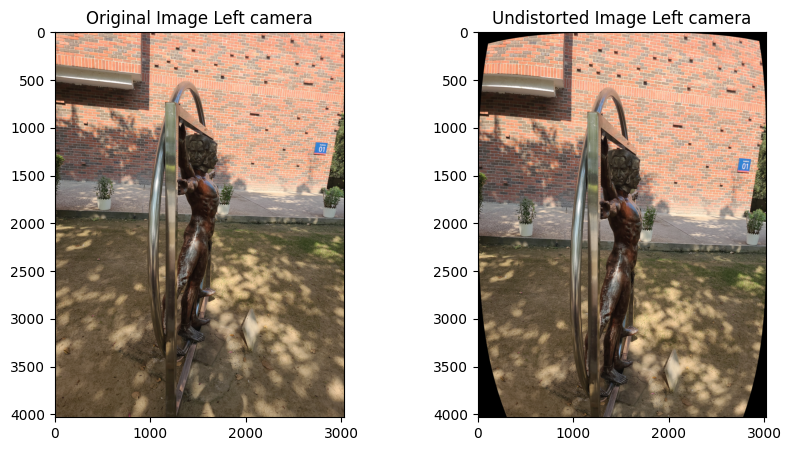

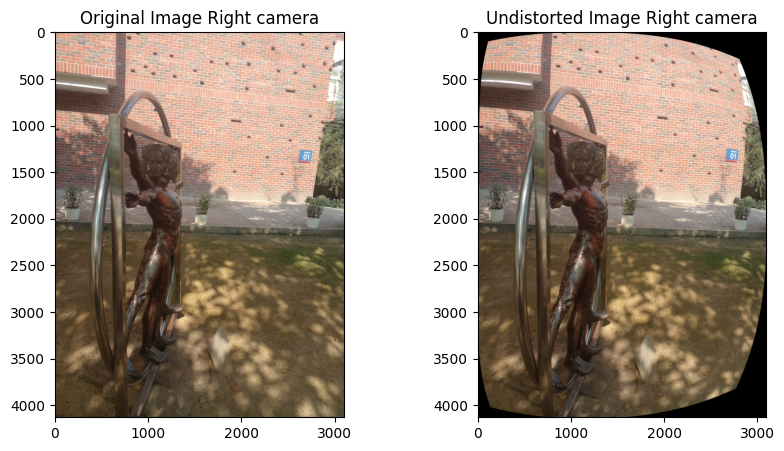

Rotation matrix:
[[ 0.99619233 -0.08623768 -0.0128025 ]
 [ 0.08485558  0.99279191 -0.08463895]
 [ 0.02000928  0.08323031  0.99632944]]
Translation vector:
[[-0.80901473]
 [ 0.25475681]
 [ 0.52971137]]


In [48]:
# use the intrinsics and distortion coefficients to undistort the images, and get the extrinsics

import cv2
import matplotlib.pyplot as plt

img1 = cv2.imread('datasets/Aryan_maingate_statue/1.jpg')
img2 = cv2.imread('datasets/shreyansh_maingate_statue/1.jpg')

K1 = callibration1
D1 = distortion1
K2 = callibration2
D2 = distortion2

# 1. first we need to undistort the images
h1, w1 = img1.shape[:2]
newK1, roi1 = cv2.getOptimalNewCameraMatrix(K1, D1, (w1, h1), 1, (w1, h1))

h2, w2 = img2.shape[:2]
newK2, roi2 = cv2.getOptimalNewCameraMatrix(K2, D2, (w2, h2), 1, (w2, h2))


img1_undistorted = cv2.undistort(img1, K1, D1, None, newK1)
img2_undistorted = cv2.undistort(img2, K2, D2, None, newK2)

# plot original and undistorted images
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
plt.title('Original Image Left camera')
plt.subplot(122)
plt.imshow(cv2.cvtColor(img1_undistorted, cv2.COLOR_BGR2RGB))
plt.title('Undistorted Image Left camera')
plt.show()
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
plt.title('Original Image Right camera')
plt.subplot(122)
plt.imshow(cv2.cvtColor(img2_undistorted, cv2.COLOR_BGR2RGB))
plt.title('Undistorted Image Right camera')
plt.show()

# 2. then we perform feature detection and get matching keypoints

img1_undistorted_copy = img1_undistorted.copy()
img2_undistorted_copy = img2_undistorted.copy()

sift = cv2.SIFT_create()
kp1, des1 = sift.detectAndCompute(img1_undistorted, None)
kp2, des2 = sift.detectAndCompute(img2_undistorted, None)
# match features using FLANN
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50)
flann = cv2.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(des1, des2, k=2)
# filter out the bad matches using lowe's ratio test
good_matches = []
good_matches = [m for m, n in matches if m.distance < 0.7 * n.distance] 
# get the matched keypoints
pts1 = np.float32([kp1[m.queryIdx].pt for m in good_matches])
pts2 = np.float32([kp2[m.trainIdx].pt for m in good_matches])

# 3. next we use the matched keypoints to get the fundamental matrix
F, mask = cv2.findFundamentalMat(pts1, pts2, cv2.FM_LMEDS)
# we select only inlier points
pts1 = pts1[mask.ravel() == 1]
pts2 = pts2[mask.ravel() == 1]

# 4. we use the fundamental matrix to get the essential matrix
E = np.dot(np.dot(K2.T, F), K1)
# we decompose the essential matrix to get the rotation and translation
_, R, t, mask = cv2.recoverPose(E, pts1, pts2, K1)

print("Rotation matrix:")
print(R)
print("Translation vector:")
print(t)

## 3. We use homography to verify that our rotation and translation matrices are correct

Undistorted points (Image 1):
[[[1.5842004e+03 1.7414358e+03]]

 [[1.5842004e+03 1.4142011e+07]]

 [[9.2761930e+06 1.4142011e+07]]

 [[9.2761930e+06 1.7414358e+03]]]
Projected points (Image 2):
[[[-561.60425  163.99612]]

 [[-618.7314  4161.723  ]]

 [[2604.3625  3999.0227 ]]

 [[2450.5935   170.6991 ]]]


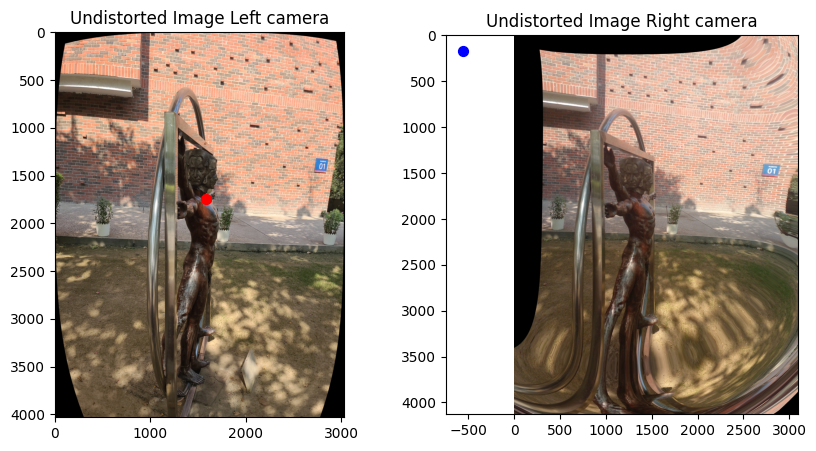

In [ ]:
import matplotlib.pyplot as plt

P1 = np.dot(newK1, np.hstack((np.eye(3), np.zeros((3, 1))))) # P1 = K1 * [I|0]
P2 = np.dot(newK2, np.hstack((R, t))) # P2 = K2 * [R|t] (R and t are with respect to the first camera)

H1 = newK1 @ np.eye(3)  # Homography for left camera
H2 = newK2 @ R @ np.linalg.inv(newK1)  # Homography for right camera

h, w = img1_undistorted.shape[:2]
points = np.array([[0, 0], [0, h - 1], [w - 1, h - 1], [w - 1, 0]], dtype=np.float32).reshape(-1, 1, 2)
undistorted_points = cv2.perspectiveTransform(points, H1)
projected_points = cv2.perspectiveTransform(points, H2)

print("Undistorted points (Image 1):")
print(undistorted_points)
print("Projected points (Image 2):")
print(projected_points)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(cv2.cvtColor(img1_undistorted_copy, cv2.COLOR_BGR2RGB))
axs[0].scatter(undistorted_points[0, :, 0], undistorted_points[0, :, 1], c='red', s=50, label='Points')
axs[0].set_title('Undistorted Image Left camera')
axs[1].imshow(cv2.cvtColor(img2_undistorted_copy, cv2.COLOR_BGR2RGB))
axs[1].scatter(projected_points[0, :, 0], projected_points[0, :, 1], c='blue', s=50, label='Points')
axs[1].set_title('Undistorted Image Right camera')
plt.show()


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Intrinsics and extrinsics
P1 = np.dot(newK1, np.hstack((np.eye(3), np.zeros((3, 1)))))  # Left camera matrix
P2 = np.dot(newK2, np.hstack((R, t)))  # Right camera matrix

# Create a proper homography matrix
H1 = newK1 @ np.eye(3)  # Homography for left camera
H2 = newK2 @ R @ np.linalg.inv(newK1)  # Homography for right camera

# Transform image corners using homography
h, w = img1_undistorted.shape[:2]
points = np.array([[0, 0], [0, h - 1], [w - 1, h - 1], [w - 1, 0]], dtype=np.float32).reshape(-1, 1, 2)

# Perspective transform using the homography
undistorted_points = cv2.perspectiveTransform(points, H1)
projected_points = cv2.perspectiveTransform(points, H2)

# Normalize points
undistorted_points = undistorted_points / undistorted_points[:, :, 2].reshape(-1, 1, 1)
projected_points = projected_points / projected_points[:, :, 2].reshape(-1, 1, 1)

# Output results
print("Undistorted points (Image 1):")
print(undistorted_points)
print("Projected points (Image 2):")
print(projected_points)

# Plotting
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Image 1 with points
axs[0].imshow(cv2.cvtColor(img1_undistorted_copy, cv2.COLOR_BGR2RGB))
axs[0].scatter(undistorted_points[:, 0, 0], undistorted_points[:, 0, 1], c='red', s=50, label='Points')
axs[0].set_title('Undistorted Image - Left Camera')
axs[0].set_xlim(0, w)
axs[0].set_ylim(h, 0)

# Image 2 with points
axs[1].imshow(cv2.cvtColor(img2_undistorted_copy, cv2.COLOR_BGR2RGB))
axs[1].scatter(projected_points[:, 0, 0], projected_points[:, 0, 1], c='blue', s=50, label='Points')
axs[1].set_title('Undistorted Image - Right Camera')
axs[1].set_xlim(0, w)
axs[1].set_ylim(h, 0)

plt.tight_layout()
plt.show()


IndexError: index 2 is out of bounds for axis 2 with size 2